Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [5]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_8275/2882021498.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = StandardScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229755 entries, 0 to 229754
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 9.6 MB


# Execution model
## Create model

In [10]:
class LightweightMLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size, width_multiplier=1.0):
        super(LightweightMLP, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)
        
        self.linear_1 = nn.Linear(input_dim, adjusted_hidden_size)
        self.linear_2 = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        temp = F.relu(self.linear_1(x))
        return self.linear_2(temp)

Initialize model

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightMLP(features_num, hidden_neurons_num, output_neurons_num, multiplier).to(device)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

Construct Data Loader

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

    X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)
    model.eval()
    outputs = model(X_test_tensor)
    with torch.no_grad():
        probabilities = torch.sigmoid(outputs).squeeze()
        predictions = (probabilities > 0.5).float().cpu().numpy()
    
        # Calculate indicators
        acc = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
    
        print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)
    pbar.update(1)
pbar.reset()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/hueybai/miniconda3/envs/DL_Pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/100 [00:02<03:25,  2.08s/it]

Epoch [1/100], Loss: 0.7084165389562561, Accuracy: 0.8288403098602712
Accuracy:  0.8622538693222375 , Precision:  0.0 , Recall:  0.0 , F1:  0.0


/Users/hueybai/miniconda3/envs/DL_Pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 2/100 [00:04<03:32,  2.17s/it]

Epoch [2/100], Loss: 0.5397061552068193, Accuracy: 0.8412835521548112
Accuracy:  0.8622538693222375 , Precision:  0.0 , Recall:  0.0 , F1:  0.0


/Users/hueybai/miniconda3/envs/DL_Pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

Epoch [3/100], Loss: 0.5135111250314891, Accuracy: 0.8451266928233349
Accuracy:  0.8622538693222375 , Precision:  0.0 , Recall:  0.0 , F1:  0.0


  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

Epoch [4/100], Loss: 0.4949499643440981, Accuracy: 0.85489411361732
Accuracy:  0.8684169292640889 , Precision:  0.5758354755784062 , Recall:  0.1698685540950455 , F1:  0.26234628147569783


  5%|▌         | 5/100 [00:10<03:17,  2.08s/it]

Epoch [5/100], Loss: 0.4811282944169227, Accuracy: 0.8672504854836154
Accuracy:  0.843590591758213 , Precision:  0.42538975501113585 , Recall:  0.3862487360970677 , F1:  0.40487546369899313


  6%|▌         | 6/100 [00:12<03:14,  2.07s/it]

Epoch [6/100], Loss: 0.4715953055193358, Accuracy: 0.8790410495504677
Accuracy:  0.827399502080468 , Precision:  0.39371416436610746 , Recall:  0.46865520728008087 , F1:  0.42792844777841893


  7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

Epoch [7/100], Loss: 0.4639836655261376, Accuracy: 0.8893474562357044
Accuracy:  0.8234474834171904 , Precision:  0.39035907525823904 , Recall:  0.5015166835187057 , F1:  0.43901089782596664


  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

Epoch [8/100], Loss: 0.45716721081455597, Accuracy: 0.896320126197432
Accuracy:  0.8234997127387316 , Precision:  0.3931246399078164 , Recall:  0.5174418604651163 , F1:  0.4467969005784132


  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

Epoch [9/100], Loss: 0.4509016789470813, Accuracy: 0.9013514632447857
Accuracy:  0.8260415397203991 , Precision:  0.4003831417624521 , Recall:  0.5283114256825076 , F1:  0.455536181342633


 10%|█         | 10/100 [00:21<03:15,  2.17s/it]

Epoch [10/100], Loss: 0.44526803129705306, Accuracy: 0.9049943949996604
Accuracy:  0.8273298629850798 , Precision:  0.40333461835003853 , Recall:  0.5289433771486349 , F1:  0.4576771653543306


 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

Epoch [11/100], Loss: 0.44011689426680983, Accuracy: 0.9079151875693549
Accuracy:  0.8293319869774891 , Precision:  0.4075124718771398 , Recall:  0.5265419615773509 , F1:  0.4594430658946788


 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

Epoch [12/100], Loss: 0.435453563465527, Accuracy: 0.9103568658423353
Accuracy:  0.8299587388359825 , Precision:  0.4086116858803823 , Recall:  0.5241405460060667 , F1:  0.4592215270472289


 13%|█▎        | 13/100 [00:27<03:04,  2.12s/it]

Epoch [13/100], Loss: 0.43117667459584963, Accuracy: 0.9124024786557058
Accuracy:  0.8353905882762583 , Precision:  0.42083119548486403 , Recall:  0.5183265925176946 , F1:  0.46451832134564197


 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

Epoch [14/100], Loss: 0.427193078524332, Accuracy: 0.9141695399370429
Accuracy:  0.8374623513640558 , Precision:  0.42577147623019185 , Recall:  0.5161779575328614 , F1:  0.466636197440585


 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

Epoch [15/100], Loss: 0.42372187482841395, Accuracy: 0.9157017502887425
Accuracy:  0.8386636257595014 , Precision:  0.4286616826366221 , Recall:  0.5145348837209303 , F1:  0.4676891263139755


 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

Epoch [16/100], Loss: 0.4206110430296657, Accuracy: 0.9169291179767648
Accuracy:  0.8413795504796393 , Precision:  0.43529411764705883 , Recall:  0.509732052578362 , F1:  0.4695814170111195


 17%|█▋        | 17/100 [00:36<02:56,  2.12s/it]

Epoch [17/100], Loss: 0.41783998680359646, Accuracy: 0.9179214578096339
Accuracy:  0.8431379376381901 , Precision:  0.43964379947229554 , Recall:  0.5054347826086957 , F1:  0.47024929444967073


 18%|█▊        | 18/100 [00:38<02:55,  2.14s/it]

Epoch [18/100], Loss: 0.41534715831086483, Accuracy: 0.9187919313472384
Accuracy:  0.844948554118282 , Precision:  0.4444444444444444 , Recall:  0.5025278058645096 , F1:  0.4717048285680389


 19%|█▉        | 19/100 [00:40<02:55,  2.17s/it]

Epoch [19/100], Loss: 0.41308232708111264, Accuracy: 0.9194491388681296
Accuracy:  0.8459757307752572 , Precision:  0.4470974312549508 , Recall:  0.4993680485338726 , F1:  0.4717893605588393


 20%|██        | 20/100 [00:42<02:52,  2.16s/it]

Epoch [20/100], Loss: 0.4110192688492701, Accuracy: 0.9200584703444528
Accuracy:  0.8471770051707028 , Precision:  0.4504463263904784 , Recall:  0.4974721941354904 , F1:  0.47279279279279274


 21%|██        | 21/100 [00:44<02:47,  2.12s/it]

Epoch [21/100], Loss: 0.40912815436935845, Accuracy: 0.9206329828792718
Accuracy:  0.8483434600184544 , Precision:  0.4537455134884798 , Recall:  0.49532355915065723 , F1:  0.4736237839144359


 22%|██▏       | 22/100 [00:46<02:43,  2.10s/it]

Epoch [22/100], Loss: 0.4073741372853627, Accuracy: 0.921072572015762
Accuracy:  0.8497884712477585 , Precision:  0.45789226064455424 , Recall:  0.49203741152679475 , F1:  0.47435116364079444


 23%|██▎       | 23/100 [00:48<02:40,  2.08s/it]

Epoch [23/100], Loss: 0.4057301563254503, Accuracy: 0.921468637475372
Accuracy:  0.8517731854663207 , Precision:  0.4639865996649916 , Recall:  0.49014155712841256 , F1:  0.4767055931161648


 24%|██▍       | 24/100 [00:50<02:39,  2.10s/it]

Epoch [24/100], Loss: 0.40419942967191397, Accuracy: 0.921860350567294
Accuracy:  0.8536012117202597 , Precision:  0.469882438492304 , Recall:  0.49001516683518703 , F1:  0.4797376724617955


 25%|██▌       | 25/100 [00:52<02:35,  2.08s/it]

Epoch [25/100], Loss: 0.4027787180174521, Accuracy: 0.922256416026904
Accuracy:  0.8552203206880342 , Precision:  0.4751659700024588 , Recall:  0.48849848331648127 , F1:  0.4817399975071669


 26%|██▌       | 26/100 [00:54<02:32,  2.06s/it]

Epoch [26/100], Loss: 0.40145693944368616, Accuracy: 0.9226308965735898
Accuracy:  0.856961298072738 , Precision:  0.4810568295114656 , Recall:  0.4878665318503539 , F1:  0.48443775100401604


 27%|██▋       | 27/100 [00:56<02:28,  2.04s/it]

Epoch [27/100], Loss: 0.4002212208172579, Accuracy: 0.9229486194148153
Accuracy:  0.8587022754574418 , Precision:  0.48710819009100104 , Recall:  0.48710819009100104 , F1:  0.48710819009100104


 28%|██▊       | 28/100 [00:58<02:26,  2.03s/it]

Epoch [28/100], Loss: 0.3990575548171821, Accuracy: 0.9232968088298571
Accuracy:  0.8612092828914153 , Precision:  0.49613302397525133 , Recall:  0.4864762386248736 , F1:  0.4912571793235482


 29%|██▉       | 29/100 [01:00<02:23,  2.03s/it]

Epoch [29/100], Loss: 0.3979594937150635, Accuracy: 0.923658055347963
Accuracy:  0.8635421925869183 , Precision:  0.5048607461902259 , Recall:  0.48571789686552075 , F1:  0.495104354547797


 30%|███       | 30/100 [01:03<02:24,  2.06s/it]

Epoch [30/100], Loss: 0.3969237061215522, Accuracy: 0.9240323589691329
Accuracy:  0.8658228729608802 , Precision:  0.5137454740512271 , Recall:  0.484201213346815 , F1:  0.4985360140542651


 31%|███       | 31/100 [01:05<02:21,  2.05s/it]

Epoch [31/100], Loss: 0.39594218680999793, Accuracy: 0.9243718436487987
Accuracy:  0.8683472901687007 , Precision:  0.5239594742606791 , Recall:  0.483695652173913 , F1:  0.5030231335436384


 32%|███▏      | 32/100 [01:07<02:18,  2.04s/it]

Epoch [32/100], Loss: 0.39501206502271363, Accuracy: 0.9247026235930883
Accuracy:  0.8713765908180853 , Precision:  0.5367461430575035 , Recall:  0.483695652173913 , F1:  0.5088419093205692


 33%|███▎      | 33/100 [01:09<02:15,  2.03s/it]

Epoch [33/100], Loss: 0.39412743459562255, Accuracy: 0.9250116416989379
Accuracy:  0.8741969741813054 , Precision:  0.5492250287026407 , Recall:  0.483695652173913 , F1:  0.5143817204301075


 34%|███▍      | 34/100 [01:11<02:14,  2.04s/it]

Epoch [34/100], Loss: 0.3932914834513254, Accuracy: 0.9253598311139797
Accuracy:  0.8771914552829959 , Precision:  0.5632556767915069 , Recall:  0.4828109201213347 , F1:  0.519940111610181


 35%|███▌      | 35/100 [01:13<02:13,  2.06s/it]

Epoch [35/100], Loss: 0.3924975476741832, Accuracy: 0.9257384871028377
Accuracy:  0.8802381657062275 , Precision:  0.5782931635591936 , Recall:  0.48217896865520726 , F1:  0.5258804879729823


 36%|███▌      | 36/100 [01:15<02:16,  2.14s/it]

Epoch [36/100], Loss: 0.3917485095323986, Accuracy: 0.9261171430916956
Accuracy:  0.8829192708786713 , Precision:  0.5922013360260991 , Recall:  0.48179979777553084 , F1:  0.5313262248240296


 37%|███▋      | 37/100 [01:17<02:05,  1.99s/it]

Epoch [37/100], Loss: 0.39104446854189984, Accuracy: 0.9263782851529769
Accuracy:  0.8856003760511151 , Precision:  0.6068866571018652 , Recall:  0.48116784630940346 , F1:  0.5367641875220303


 38%|███▊      | 38/100 [01:18<01:56,  1.88s/it]

Epoch [38/100], Loss: 0.39037997530896223, Accuracy: 0.9266873032588265
Accuracy:  0.8880725639373944 , Precision:  0.621140336546316 , Recall:  0.480535894843276 , F1:  0.541865602508373


 39%|███▉      | 39/100 [01:20<01:49,  1.80s/it]

Epoch [39/100], Loss: 0.38975020028328583, Accuracy: 0.9270093784677401
Accuracy:  0.8898483608697924 , Precision:  0.632149408037352 , Recall:  0.47914560161779574 , F1:  0.5451146739521173


 40%|████      | 40/100 [01:22<01:44,  1.74s/it]

Epoch [40/100], Loss: 0.38914724086597535, Accuracy: 0.9273619202504699
Accuracy:  0.8917286164452723 , Precision:  0.643889172191059 , Recall:  0.4787664307381193 , F1:  0.5491844871330192


 41%|████      | 41/100 [01:23<01:40,  1.70s/it]

Epoch [41/100], Loss: 0.3885683938362469, Accuracy: 0.9276361194148154
Accuracy:  0.893417364508435 , Precision:  0.6548442906574394 , Recall:  0.4783872598584429 , F1:  0.5528775927548933


 42%|████▏     | 42/100 [01:25<01:36,  1.67s/it]

Epoch [42/100], Loss: 0.38801500382746335, Accuracy: 0.9279712517267931
Accuracy:  0.8946534584515747 , Precision:  0.6635612585691686 , Recall:  0.47712335692618807 , F1:  0.5551062421880744


 43%|████▎     | 43/100 [01:26<01:35,  1.67s/it]

Epoch [43/100], Loss: 0.3874918471195786, Accuracy: 0.9281975748465702
Accuracy:  0.8963596162885844 , Precision:  0.6750670241286864 , Recall:  0.477376137512639 , F1:  0.5592655660028134


 44%|████▍     | 44/100 [01:28<01:32,  1.66s/it]

Epoch [44/100], Loss: 0.3869961708793832, Accuracy: 0.9285979926738682
Accuracy:  0.8974738418147948 , Precision:  0.6835420068953003 , Recall:  0.4761122345803842 , F1:  0.5612754227817924


 45%|████▌     | 45/100 [01:30<01:31,  1.66s/it]

Epoch [45/100], Loss: 0.38652482372184194, Accuracy: 0.9288025539552053
Accuracy:  0.8989014432702519 , Precision:  0.6943674976915974 , Recall:  0.4752275025278059 , F1:  0.5642680273129737


 46%|████▌     | 46/100 [01:31<01:29,  1.65s/it]

Epoch [46/100], Loss: 0.38608248423060115, Accuracy: 0.9291072196933668
Accuracy:  0.8999112101533802 , Precision:  0.7026419336706015 , Recall:  0.47396359959555107 , F1:  0.5660804589025586


 47%|████▋     | 47/100 [01:33<01:27,  1.65s/it]

Epoch [47/100], Loss: 0.38565872320282907, Accuracy: 0.9293030762393278
Accuracy:  0.9013039920611431 , Precision:  0.7137411854392987 , Recall:  0.4733316481294237 , F1:  0.5691921878562202


 48%|████▊     | 48/100 [01:35<01:29,  1.72s/it]

Epoch [48/100], Loss: 0.3852566119300219, Accuracy: 0.929516342256041
Accuracy:  0.9024704469088947 , Precision:  0.7235772357723578 , Recall:  0.4724469160768453 , F1:  0.5716470408319315


 49%|████▉     | 49/100 [01:37<01:26,  1.71s/it]

Epoch [49/100], Loss: 0.38487702847611505, Accuracy: 0.929725255905066
Accuracy:  0.9036717213043403 , Precision:  0.7345691185170578 , Recall:  0.47080384226491406 , F1:  0.5738273126396056


 50%|█████     | 50/100 [01:38<01:24,  1.69s/it]

Epoch [50/100], Loss: 0.38451763206717887, Accuracy: 0.929956108318047
Accuracy:  0.9048555859259388 , Precision:  0.7454363089267804 , Recall:  0.4696663296258847 , F1:  0.5762580445064744


 51%|█████     | 51/100 [01:40<01:22,  1.68s/it]

Epoch [51/100], Loss: 0.3841764158163415, Accuracy: 0.9300997364517517
Accuracy:  0.9060742700952314 , Precision:  0.7563658586270117 , Recall:  0.4692871587462083 , F1:  0.5792059901723734


 52%|█████▏    | 52/100 [01:42<01:21,  1.70s/it]

Epoch [52/100], Loss: 0.38385501703793967, Accuracy: 0.9303434690422809
Accuracy:  0.9068751196921953 , Precision:  0.7654858089910918 , Recall:  0.4670121334681496 , F1:  0.5801083287542194


 53%|█████▎    | 53/100 [01:43<01:18,  1.68s/it]

Epoch [53/100], Loss: 0.3835518155931293, Accuracy: 0.9304827448082977
Accuracy:  0.9077630181583941 , Precision:  0.7745798319327731 , Recall:  0.4660010111223458 , F1:  0.5819128787878788


 54%|█████▍    | 54/100 [01:45<01:16,  1.66s/it]

Epoch [54/100], Loss: 0.38326599112322524, Accuracy: 0.9306611918835066
Accuracy:  0.9085290482076638 , Precision:  0.7824054398640033 , Recall:  0.4653690596562184 , F1:  0.5836107148517989


 55%|█████▌    | 55/100 [01:47<01:14,  1.66s/it]

Epoch [55/100], Loss: 0.38299876170844205, Accuracy: 0.9307656487080191
Accuracy:  0.9093298978046275 , Precision:  0.7905027932960894 , Recall:  0.46498988877654196 , F1:  0.5855483049498648


 56%|█████▌    | 56/100 [01:48<01:12,  1.65s/it]

Epoch [56/100], Loss: 0.3827430502077365, Accuracy: 0.9309138061349277
Accuracy:  0.9099392398892738 , Precision:  0.7971360381861575 , Recall:  0.4643579373104146 , F1:  0.5868540851369699


 57%|█████▋    | 57/100 [01:50<01:10,  1.65s/it]

Epoch [57/100], Loss: 0.38250202462750027, Accuracy: 0.9310530819009444
Accuracy:  0.9106704503908494 , Precision:  0.8042003937869175 , Recall:  0.46461071789686553 , F1:  0.5889609869422414


 58%|█████▊    | 58/100 [01:51<01:08,  1.64s/it]

Epoch [58/100], Loss: 0.38227125589913613, Accuracy: 0.931166243460833
Accuracy:  0.910914187224708 , Precision:  0.8082947275534966 , Recall:  0.46309403437815977 , F1:  0.5888308557653676


 59%|█████▉    | 59/100 [01:53<01:07,  1.64s/it]

Epoch [59/100], Loss: 0.3820507469279668, Accuracy: 0.9313011668591616
Accuracy:  0.9114887097616602 , Precision:  0.8153434433541481 , Recall:  0.4620829120323559 , F1:  0.5898676992578251


 60%|██████    | 60/100 [01:55<01:05,  1.63s/it]

Epoch [60/100], Loss: 0.38184041185300266, Accuracy: 0.9314230331544263
Accuracy:  0.9120110029770714 , Precision:  0.8222823635543527 , Recall:  0.4608190091001011 , F1:  0.5906366434472703


 61%|██████    | 61/100 [01:56<01:03,  1.63s/it]

Epoch [61/100], Loss: 0.3816375172872911, Accuracy: 0.9315057281404987
Accuracy:  0.9123940180017062 , Precision:  0.8278688524590164 , Recall:  0.4595551061678463 , F1:  0.5910273081924577


 62%|██████▏   | 62/100 [01:58<01:02,  1.63s/it]

Epoch [62/100], Loss: 0.381442184513073, Accuracy: 0.931584070758883
Accuracy:  0.9127073939309528 , Precision:  0.8326446280991735 , Recall:  0.458417593528817 , F1:  0.591294424519074


 63%|██████▎   | 63/100 [02:00<01:02,  1.68s/it]

Epoch [63/100], Loss: 0.3812572368204221, Accuracy: 0.9316711181126436
Accuracy:  0.9130555894078936 , Precision:  0.8371072088724584 , Recall:  0.45791203235591504 , F1:  0.5919934640522876


 64%|██████▍   | 64/100 [02:02<01:02,  1.73s/it]

Epoch [64/100], Loss: 0.38108517012397203, Accuracy: 0.9317842796725321
Accuracy:  0.913247096920211 , Precision:  0.8414548845884822 , Recall:  0.45614256825075833 , F1:  0.5915908532087534


 65%|██████▌   | 65/100 [02:03<01:00,  1.73s/it]

Epoch [65/100], Loss: 0.3809208112184206, Accuracy: 0.9318234509817244
Accuracy:  0.9135082435279166 , Precision:  0.8461900282220132 , Recall:  0.45475227502527804 , F1:  0.5915817165406115


 66%|██████▌   | 66/100 [02:05<00:58,  1.71s/it]

Epoch [66/100], Loss: 0.3807650943572512, Accuracy: 0.9319061459677968
Accuracy:  0.9136475217186929 , Precision:  0.8500948766603416 , Recall:  0.4529828109201213 , F1:  0.5910290237467019


 67%|██████▋   | 67/100 [02:07<00:56,  1.71s/it]

Epoch [67/100], Loss: 0.380619384213004, Accuracy: 0.9319453172769889
Accuracy:  0.9139086683263984 , Precision:  0.8549892318736539 , Recall:  0.45159251769464104 , F1:  0.5910181126457696


 68%|██████▊   | 68/100 [02:09<00:57,  1.79s/it]

Epoch [68/100], Loss: 0.38048211017144457, Accuracy: 0.9319714314831171
Accuracy:  0.9140131269694807 , Precision:  0.8582791033984093 , Recall:  0.4500758341759353 , F1:  0.5904983003067739


 69%|██████▉   | 69/100 [02:11<00:58,  1.89s/it]

Epoch [69/100], Loss: 0.3803517624102506, Accuracy: 0.9320062504246213
Accuracy:  0.9142568638033391 , Precision:  0.8624120359136132 , Recall:  0.44919110212335694 , F1:  0.5907088839026012


 70%|███████   | 70/100 [02:13<00:58,  1.94s/it]

Epoch [70/100], Loss: 0.38022899134488924, Accuracy: 0.9320584788368775
Accuracy:  0.9144135517679626 , Precision:  0.865544167886774 , Recall:  0.44830637007077856 , F1:  0.5906744379683596


 71%|███████   | 71/100 [02:15<00:56,  1.96s/it]

Epoch [71/100], Loss: 0.3801102763323454, Accuracy: 0.9320889454106936
Accuracy:  0.9144483713156566 , Precision:  0.8686669945892769 , Recall:  0.44641051567239637 , F1:  0.5897478710970112


 72%|███████▏  | 72/100 [02:17<00:55,  1.99s/it]

Epoch [72/100], Loss: 0.37999591408262356, Accuracy: 0.9321281167198859
Accuracy:  0.9144657810895036 , Precision:  0.8712552612032681 , Recall:  0.44476744186046513 , F1:  0.5889046941678521


 73%|███████▎  | 73/100 [02:19<00:55,  2.05s/it]

Epoch [73/100], Loss: 0.3798888580028241, Accuracy: 0.9321932253096904
Accuracy:  0.9144831908633507 , Precision:  0.8738783649052841 , Recall:  0.4431243680485339 , F1:  0.5880576987588058


 74%|███████▍  | 74/100 [02:21<00:54,  2.08s/it]

Epoch [74/100], Loss: 0.3797873930502674, Accuracy: 0.9321932253096904
Accuracy:  0.9143787322202684 , Precision:  0.875 , Recall:  0.44148129423660265 , F1:  0.586861559139785


 75%|███████▌  | 75/100 [02:23<00:52,  2.09s/it]

Epoch [75/100], Loss: 0.37969316903549827, Accuracy: 0.9322236918835066
Accuracy:  0.9142742735771863 , Precision:  0.8767019667170953 , Recall:  0.43945904954499493 , F1:  0.5854520963125105


 76%|███████▌  | 76/100 [02:26<00:51,  2.13s/it]

Epoch [76/100], Loss: 0.37960344079344976, Accuracy: 0.9322323966188827
Accuracy:  0.914187224707951 , Precision:  0.8780735107731306 , Recall:  0.4378159757330637 , F1:  0.584296196339715


 77%|███████▋  | 77/100 [02:28<00:49,  2.15s/it]

Epoch [77/100], Loss: 0.37951861571462436, Accuracy: 0.9322498060896347
Accuracy:  0.9140131269694807 , Precision:  0.8802762854950115 , Recall:  0.43490899898887764 , F1:  0.5821842483715421


 78%|███████▊  | 78/100 [02:30<00:47,  2.18s/it]

Epoch [78/100], Loss: 0.3794383593226763, Accuracy: 0.9322628631926988
Accuracy:  0.9139260781002455 , Precision:  0.8822771767130345 , Recall:  0.43288675429726997 , F1:  0.5808037985416313


 79%|███████▉  | 79/100 [02:32<00:46,  2.22s/it]

Epoch [79/100], Loss: 0.3793625006089208, Accuracy: 0.9322715679280749
Accuracy:  0.9139260781002455 , Precision:  0.8846552617936755 , Recall:  0.4313700707785642 , F1:  0.5799490229396771


 80%|████████  | 80/100 [02:35<00:44,  2.20s/it]

Epoch [80/100], Loss: 0.3792914276854527, Accuracy: 0.9322715679280749
Accuracy:  0.9139608976479395 , Precision:  0.88671875 , Recall:  0.43035894843276035 , F1:  0.5794758339006126


 81%|████████  | 81/100 [02:37<00:41,  2.18s/it]

Epoch [81/100], Loss: 0.3792251792910755, Accuracy: 0.932288977398827
Accuracy:  0.9139260781002455 , Precision:  0.8884816753926702 , Recall:  0.42896865520728006 , F1:  0.5785884759631775


 82%|████████▏ | 82/100 [02:39<00:39,  2.17s/it]

Epoch [82/100], Loss: 0.3791636452309385, Accuracy: 0.9322976821342029
Accuracy:  0.9138390292310102 , Precision:  0.8889472302441586 , Recall:  0.42795753286147625 , F1:  0.577766402184114


 83%|████████▎ | 83/100 [02:41<00:36,  2.17s/it]

Epoch [83/100], Loss: 0.3791067173247711, Accuracy: 0.9323237963403311
Accuracy:  0.913699751040234 , Precision:  0.8895333509095703 , Recall:  0.4264408493427705 , F1:  0.5765057667663392


 84%|████████▍ | 84/100 [02:43<00:34,  2.18s/it]

Epoch [84/100], Loss: 0.37905411128976946, Accuracy: 0.9323586152818353
Accuracy:  0.9135082435279166 , Precision:  0.8900370959194489 , Recall:  0.4245449949443883 , F1:  0.5748759199041589


 85%|████████▌ | 85/100 [02:45<00:32,  2.19s/it]

Epoch [85/100], Loss: 0.3790045476595893, Accuracy: 0.9323673200172113
Accuracy:  0.9133341457894462 , Precision:  0.8909914712153518 , Recall:  0.4225227502527806 , F1:  0.5732167352537724


 86%|████████▌ | 86/100 [02:48<00:30,  2.19s/it]

Epoch [86/100], Loss: 0.37895919274631096, Accuracy: 0.9323673200172113
Accuracy:  0.913229687146364 , Precision:  0.891653290529695 , Recall:  0.42125884732052576 , F1:  0.5721888412017166


 87%|████████▋ | 87/100 [02:50<00:28,  2.19s/it]

Epoch [87/100], Loss: 0.37891784223186387, Accuracy: 0.9323847294879635
Accuracy:  0.9131252285032817 , Precision:  0.8921095008051529 , Recall:  0.4201213346814965 , F1:  0.5712321704760268


 88%|████████▊ | 88/100 [02:52<00:26,  2.18s/it]

Epoch [88/100], Loss: 0.378880338674816, Accuracy: 0.9323455581787712
Accuracy:  0.9129859503125054 , Precision:  0.8939967550027041 , Recall:  0.4178463094034378 , F1:  0.5695090439276486


 89%|████████▉ | 89/100 [02:54<00:24,  2.20s/it]

Epoch [89/100], Loss: 0.37884560404816214, Accuracy: 0.9323455581787712
Accuracy:  0.9129511307648114 , Precision:  0.894579945799458 , Recall:  0.41721435793731043 , F1:  0.5690398207205654


 90%|█████████ | 90/100 [02:56<00:21,  2.16s/it]

Epoch [90/100], Loss: 0.37881286382319757, Accuracy: 0.9323586152818353
Accuracy:  0.9128640818955762 , Precision:  0.895725564933297 , Recall:  0.41582406471183014 , F1:  0.5679758308157099


 91%|█████████ | 91/100 [02:58<00:19,  2.12s/it]

Epoch [91/100], Loss: 0.3787834832871747, Accuracy: 0.9323586152818353
Accuracy:  0.9126551646094118 , Precision:  0.896032831737346 , Recall:  0.41392821031344795 , F1:  0.5662661018414455


 92%|█████████▏| 92/100 [03:00<00:17,  2.13s/it]

Epoch [92/100], Loss: 0.37875606250234745, Accuracy: 0.9323542629141472
Accuracy:  0.9125855255140236 , Precision:  0.8967883612407357 , Recall:  0.4129170879676441 , F1:  0.5654694937256599


 93%|█████████▎| 93/100 [03:03<00:14,  2.13s/it]

Epoch [93/100], Loss: 0.3787317819992104, Accuracy: 0.9323194439726431
Accuracy:  0.9124288375494002 , Precision:  0.8971885336273429 , Recall:  0.41140040444893833 , F1:  0.5641247833622184


 94%|█████████▍| 94/100 [03:05<00:12,  2.11s/it]

Epoch [94/100], Loss: 0.3787090425543115, Accuracy: 0.9323586152818353
Accuracy:  0.912359198454012 , Precision:  0.8981737686773658 , Recall:  0.410262891809909 , F1:  0.5632483081728266


 95%|█████████▌| 95/100 [03:07<00:10,  2.14s/it]

Epoch [95/100], Loss: 0.3786880202424251, Accuracy: 0.9323455581787712
Accuracy:  0.9122895593586239 , Precision:  0.8989450305385897 , Recall:  0.40925176946410513 , F1:  0.5624457182560361


 96%|█████████▌| 96/100 [03:09<00:08,  2.14s/it]

Epoch [96/100], Loss: 0.3786706111710836, Accuracy: 0.9323368534433952
Accuracy:  0.9121502811678476 , Precision:  0.8996095928611266 , Recall:  0.40773508594539937 , F1:  0.5611410680118282


 97%|█████████▋| 97/100 [03:11<00:06,  2.15s/it]

Epoch [97/100], Loss: 0.37865513836280845, Accuracy: 0.9323412058110833
Accuracy:  0.9120284127509184 , Precision:  0.8998601398601399 , Recall:  0.4065975733063701 , F1:  0.5601114303125272


 98%|█████████▊| 98/100 [03:13<00:04,  2.17s/it]

Epoch [98/100], Loss: 0.3786416643755612, Accuracy: 0.9323499105464592
Accuracy:  0.9119065443339891 , Precision:  0.8998878295008412 , Recall:  0.4055864509605662 , F1:  0.5591566474995644


 99%|█████████▉| 99/100 [03:16<00:02,  2.17s/it]

Epoch [99/100], Loss: 0.3786296290076598, Accuracy: 0.9323542629141472
Accuracy:  0.911836905238601 , Precision:  0.9004499437570304 , Recall:  0.40470171890798784 , F1:  0.5584234391349843


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.37861876567116587, Accuracy: 0.9323281487080192
Accuracy:  0.9116628075001306 , Precision:  0.9003950338600452 , Recall:  0.4033114256825076 , F1:  0.5570879888268156


Visualizing the training process

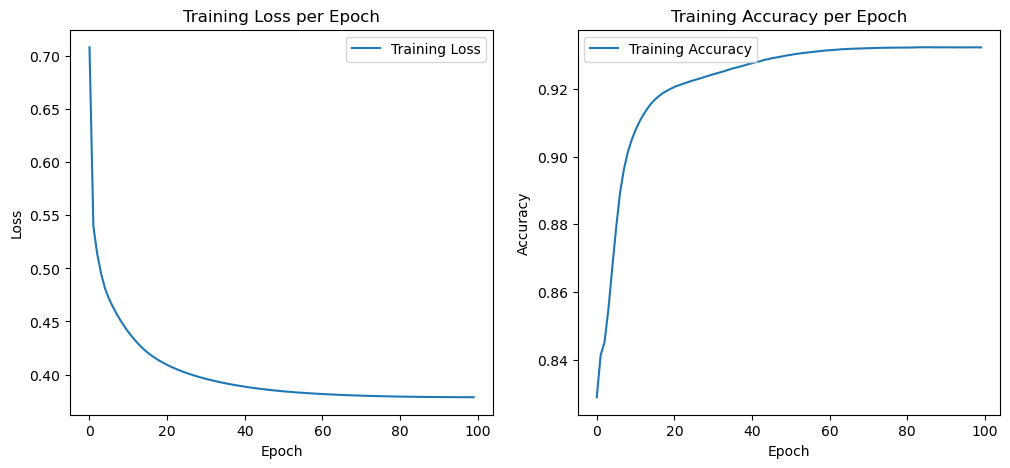

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs).squeeze()
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.9116628075001306 , Precision:  0.9003950338600452 , Recall:  0.4033114256825076 , F1:  0.5570879888268156


Save model

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_rnn_{current_time}.pt"
full_path = os.path.join(save_folder, model_filename)
torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: save_model/model_rnn_2023-11-22_06-37-04.pt
